# Introduction

The "Insurance Company Benchmark" database contains a variety of records corresponding to different clients. Each client record includes sociodemographic attributes and figures that indicate the quantity and contribution of various types of insurance policies. The dataset includes both categorical and numerical data.

The file https://kdd.ics.uci.edu/databases/tic/dictionary.txt provides an explanation of the model's variables.

The business objective, from the perspective of an insurance company, is to predict whether a client will purchase a insurance policy based on the available data.

# Libraries

The libraries that we will use are the following

In [3]:
# Standard library
from pathlib import Path

# scientific/python stack
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# scikit-learn
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    f1_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, RobustScaler, StandardScaler

# XGBoost
from xgboost import XGBClassifier

# Data Preparation

## Import data
First, we will import the csv file that contains the data

In [4]:
df = pd.read_csv('../data/raw/insurance_company_modified.csv', header=None)

## Data inspection

We will have a first look to the data and it quality

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,33,1,3,2,8,0,5,1.1,3.1,7,...,0.38,0.39,1.13,0.40,0.41,0.42,0.43,0.44,0.45,mixed_type_col
1,37.0,1.0,2.0,2.0,8.0,1.0,4.0,?,4.0,6.0,...,0.0,0.0,1.0,invalid,0.0,0.0,0.0,0.0,0.0,108
2,37.0,1.0,2.0,2.0,8.0,0.0,4.0,2.0,4.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,unknown
3,9.0,1.0,3.0,3.0,3.0,2.0,3.0,2.0,4.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,904
4,40.0,1.0,4.0,2.0,10.0,1.0,4.0,1.0,4.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,bad


In [6]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
count,5870,5865,5874,5869,5878,5864,5859,5875,5876,5877,...,5881,5871,5872,5867,5891,5890,5877,5876,5859,5345
unique,155,82,76,86,80,50,81,65,65,90,...,38,33,63,39,40,43,41,40,32,987
top,33.0,1.0,3.0,3.0,8.0,0.0,4.0,0.0,3.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,bad
freq,768,4953,2513,2806,1478,3048,1507,1918,1386,1573,...,5489,5532,2861,5537,5513,5415,5523,5444,5173,586


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5938 entries, 0 to 5937
Data columns (total 87 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5870 non-null   object
 1   1       5865 non-null   object
 2   2       5874 non-null   object
 3   3       5869 non-null   object
 4   4       5878 non-null   object
 5   5       5864 non-null   object
 6   6       5859 non-null   object
 7   7       5875 non-null   object
 8   8       5876 non-null   object
 9   9       5877 non-null   object
 10  10      5872 non-null   object
 11  11      5872 non-null   object
 12  12      5872 non-null   object
 13  13      5853 non-null   object
 14  14      5878 non-null   object
 15  15      5867 non-null   object
 16  16      5875 non-null   object
 17  17      5875 non-null   object
 18  18      5856 non-null   object
 19  19      5871 non-null   object
 20  20      5860 non-null   object
 21  21      5853 non-null   object
 22  22      5886 non-null   

Initial data inspection reveals that the dataset requires thorough cleaning. It contains missing values, outliers, non-numeric entries in expected numeric fields, and redundant columns that may not contribute to the analysis.

## Data Cleaning

We will clean the dataset by considering the nature and type of each variable—whether categorical, numerical, or otherwise. This process ensures consistency, accuracy, and readiness for analysis. For detailed descriptions of each variable, please refer to the dictionary.txt file.

In [9]:
"""
This script is intended for Google Colab (or local use). It does **NOT** require the original CSV and does not use
command-line arguments. It uses internal variables to configure:
  - RARE_THRESHOLD (rarity threshold)
  - AUTO_SHIFT_MAX (maximum circular shift to test)

Input/Output (same directory as the notebook):
  Input  : 'insurance_company_modified.csv'  (no headers)
  Output : 'insurance_company_cleaned_modified.csv'

"""

from pathlib import Path
import pandas as pd
import numpy as np

# =========================
# Configurable parameters
# =========================
RARE_THRESHOLD = 0.01   # 1%: out-of-range values -> NaN + impute; if >1% -> clip to expected range
AUTO_SHIFT_MAX = 0      # 0 = disabled; if >0, test circular shifts 1..K and select the best one

IN_MOD  = '../data/raw/insurance_company_modified.csv'
OUT_MOD = "../data/processed/insurance_company_cleaned_modified.csv"

# Canonical list (85 features + target)
COLS = [
"MOSTYPE","MAANTHUI","MGEMOMV","MGEMLEEF","MOSHOOFD","MGODRK","MGODPR","MGODOV","MGODGE",
"MRELGE","MRELSA","MRELOV","MFALLEEN","MFGEKIND","MFWEKIND","MOPLHOOG","MOPLMIDD","MOPLLAAG",
"MBERHOOG","MBERZELF","MBERBOER","MBERMIDD","MBERARBG","MBERARBO","MSKA","MSKB1","MSKB2","MSKC",
"MSKD","MHHUUR","MHKOOP","MAUT1","MAUT2","MAUT0","MZFONDS","MZPART","MINKM30","MINK3045","MINK4575",
"MINK7512","MINK123M","MINKGEM","MKOOPKLA","PWAPART","PWABEDR","PWALAND","PPERSAUT","PBESAUT","PMOTSCO",
"PVRAAUT","PAANHANG","PTRACTOR","PWERKT","PBROM","PLEVEN","PPERSONG","PGEZONG","PWAOREG","PBRAND",
"PZEILPL","PPLEZIER","PFIETS","PINBOED","PBYSTAND","AWAPART","AWABEDR","AWALAND","APERSAUT","ABESAUT",
"AMOTSCO","AVRAAUT","AAANHANG","ATRACTOR","AWERKT","ABROM","ALEVEN","APERSONG","AGEZONG","AWAOREG",
"ABRAND","AZEILPL","APLEZIER","AFIETS","AINBOED","ABYSTAND","CARAVAN"
]

# Expected ranges (derived from the data dictionary)
def build_expected():
    expected = {
        "MOSTYPE": (1,41),
        "MAANTHUI": (1,10),
        "MGEMOMV": (1,6),
        "MGEMLEEF": (1,6),
        "MOSHOOFD": (1,10),
        "CARAVAN": (0,1),
    }
    fields_0_9 = [
        "MGODRK","MGODPR","MGODOV","MGODGE","MRELGE","MRELSA","MRELOV","MFALLEEN","MFGEKIND","MFWEKIND",
        "MOPLHOOG","MOPLMIDD","MOPLLAAG","MBERHOOG","MBERZELF","MBERBOER","MBERMIDD","MBERARBG","MBERARBO",
        "MSKA","MSKB1","MSKB2","MSKC","MSKD","MHHUUR","MHKOOP","MAUT1","MAUT2","MAUT0","MZFONDS","MZPART",
        "MINKM30","MINK3045","MINK4575","MINK7512","MINK123M","MINKGEM","MKOOPKLA",
        "PWAPART","PWABEDR","PWALAND","PPERSAUT","PBESAUT","PMOTSCO","PVRAAUT","PAANHANG","PTRACTOR","PWERKT",
        "PBROM","PLEVEN","PPERSONG","PGEZONG","PWAOREG","PBRAND","PZEILPL","PPLEZIER","PFIETS","PINBOED","PBYSTAND",
    ]
    for f in fields_0_9:
        expected[f] = (0,9)
    a_fields = [
        "AWAPART","AWABEDR","AWALAND","APERSAUT","ABESAUT","AMOTSCO","AVRAAUT","AAANHANG",
        "ATRACTOR","AWERKT","ABROM","ALEVEN","APERSONG","AGEZONG","AWAOREG","ABRAND","AZEILPL",
        "APLEZIER","AFIETS","AINBOED","ABYSTAND"
    ]
    for a in a_fields:
        expected[a] = (1,12)
    return expected

EXPECTED = build_expected()

# =============
# Core helpers
# =============

def load_modified(path):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"No se encontró '{path}' en el directorio de trabajo.")
    df = pd.read_csv(p, header=None, dtype=str)
    # Keep only 86 columns (85 features + target)
    if df.shape[1] > len(COLS):
        df = df.iloc[:, :len(COLS)]
    if df.shape[1] < len(COLS):
        for c in range(df.shape[1], len(COLS)):
            df[c] = np.nan
    df.columns = COLS
    # Force numeric type (non-numeric -> NaN)
    df = df.apply(lambda s: pd.to_numeric(s.str.strip(), errors='coerce') if s.dtype == object else pd.to_numeric(s, errors='coerce'))
    return df


def inrange_score(df):
    total = 0
    ok = 0
    for c,(lo,hi) in EXPECTED.items():
        if c not in df.columns: continue
        s = df[c]; m = s.notna()
        total += int(m.sum())
        ok += int(((s>=lo)&(s<=hi)&m).sum())
    return ok / max(1,total)


def try_auto_shift(df, max_shift):
    if max_shift <= 0:
        return df, 0, None
    feat = [c for c in COLS if c != 'CARAVAN']
    base = df[feat].copy()
    best_df = df
    best_score = inrange_score(df)
    best_s = 0
    for s in range(1, max_shift+1):
        rolled = base.copy().iloc[:, -s:].join(base.iloc[:, :-s])
        rolled.columns = feat
        candidate = rolled.join(df[['CARAVAN']])
        score = inrange_score(candidate)
        if score > best_score:
            best_score, best_s, best_df = score, s, candidate
    return best_df, best_s, best_score


def analyze_and_repair(df, rare_threshold=0.01, verbose=True):
    report = {}
    out = df.copy()
    n = len(out)
    for col,(lo,hi) in EXPECTED.items():
        if col not in out.columns: continue
        s = out[col]
        mask_out = (~s.isna()) & ((s < lo) | (s > hi))
        cnt = int(mask_out.sum()); pct = cnt / n if n>0 else 0
        report[col] = {"min": lo, "max": hi, "bad_count": cnt, "bad_pct": float(pct)}
        if verbose and cnt>0:
            print(f"{col}: {cnt} ({pct:.2%}) fuera de rango [{lo},{hi}]")
        if cnt == 0: continue
        if pct <= rare_threshold:
            out.loc[mask_out, col] = np.nan
            if verbose: print("  -> rare -> set NaN (will be imputed)")
        else:
            out[col] = s.clip(lo, hi)
            if verbose: print("  -> widespread -> clip to range")
    return out, report


def finalize_and_save(df_repaired, out_path):
    df = df_repaired.copy()
    # Round numeric values to int while keeping NaN
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
        df[c] = df[c].round().where(~df[c].isna(), np.nan)

    policy = [c for c,v in EXPECTED.items() if v==(1,12)]
    binary = [c for c,v in EXPECTED.items() if v==(0,1)]
    catsm = [c for c in EXPECTED if c not in policy and c not in binary and EXPECTED[c][1] <= 9]

    # Imputations
    for c in catsm:
        if c in df.columns:
            mode_val = df[c].mode(dropna=True)
            fill = int(mode_val.iloc[0]) if len(mode_val)>0 else int(EXPECTED[c][0])
            df[c] = df[c].fillna(fill).astype(int)
    for c in policy:
        if c in df.columns:
            med = df[c].median(skipna=True)
            med = EXPECTED[c][0] if np.isnan(med) else med
            df[c] = df[c].fillna(int(round(med))).astype(int)
    for c in binary:
        if c in df.columns:
            mode_val = df[c].mode(dropna=True)
            fill = int(mode_val.iloc[0]) if len(mode_val)>0 else EXPECTED[c][0]
            df[c] = df[c].fillna(fill).astype(int)

    # Remaining NaNs: median
    for c in df.columns:
        if df[c].isna().any():
            med = df[c].median(skipna=True)
            df[c] = df[c].fillna(int(round(med)) if not np.isnan(med) else 0)

    # Final cast to int
    for c in df.columns:
        df[c] = df[c].astype(int)

    df.to_csv(out_path, index=False)
    return df

# =====
# main
# =====

def main():
    print("--- Data cleaning ---")
    df = load_modified(IN_MOD)
    print(f"Cargado: {df.shape}")

    # Shift heuristic (optional)
    if AUTO_SHIFT_MAX and AUTO_SHIFT_MAX > 0:
        print(f"Probando auto-shift hasta {AUTO_SHIFT_MAX} columnas...")
        shifted, s, score = try_auto_shift(df, AUTO_SHIFT_MAX)
        if s != 0:
            print(f"Shift seleccionado: +{s} (derecha) con in-range score={score:.4f}")
            df = shifted
        else:
            print("No se detectó mejora con shifts (s=0).")

    print("\n--- Analizar y reparar ---")
    repaired, report = analyze_and_repair(df, RARE_THRESHOLD, verbose=True)

    print("\n--- Imputar y guardar ---")
    cleaned = finalize_and_save(repaired, OUT_MOD)
    print(f"Guardado -> {OUT_MOD}")

    # Resumen rápido
    def quick(col):
        if col in df.columns:
            print(f"\n{col}")
            print("Antes:")
            print(df[col].value_counts(dropna=False).head(8))
            print("Después:")
            print(cleaned[col].value_counts(dropna=False).head(8))
    for c in ["MOSTYPE","MAANTHUI","AWAPART","PWAPART","CARAVAN"]:
        quick(c)

if __name__ == "__main__":
    main()


--- Data cleaning ---
Cargado: (5938, 86)

--- Analizar y reparar ---
MOSTYPE: 75 (1.26%) fuera de rango [1,41]
  -> widespread -> clip to range
MAANTHUI: 69 (1.16%) fuera de rango [1,10]
  -> widespread -> clip to range
MGEMOMV: 64 (1.08%) fuera de rango [1,6]
  -> widespread -> clip to range
MGEMLEEF: 73 (1.23%) fuera de rango [1,6]
  -> widespread -> clip to range
MOSHOOFD: 58 (0.98%) fuera de rango [1,10]
  -> rare -> set NaN (will be imputed)
CARAVAN: 22 (0.37%) fuera de rango [0,1]
  -> rare -> set NaN (will be imputed)
MGODRK: 31 (0.52%) fuera de rango [0,9]
  -> rare -> set NaN (will be imputed)
MGODPR: 56 (0.94%) fuera de rango [0,9]
  -> rare -> set NaN (will be imputed)
MGODOV: 51 (0.86%) fuera de rango [0,9]
  -> rare -> set NaN (will be imputed)
MGODGE: 40 (0.67%) fuera de rango [0,9]
  -> rare -> set NaN (will be imputed)
MRELGE: 67 (1.13%) fuera de rango [0,9]
  -> widespread -> clip to range
MRELSA: 49 (0.83%) fuera de rango [0,9]
  -> rare -> set NaN (will be imputed)


# Exploratory Data Analysis

Once data cleaning is complete, we will conduct a thorough exploratory analysis to uncover meaningful patterns and relationships within the dataset. This step will help us generate insights, validate assumptions, and guide the preparation of features for subsequent modeling stages.

In [10]:
df_cleaned = pd.read_csv("../data/processed/insurance_company_cleaned_modified.csv")

We observed that the dataset contains three types of variables:

* Nominal categorical variables (2)

* Ordinal numerical variables (60)

* Discrete numerical variables (23)

In [11]:

# Nombres descriptivos (85 features + target)
long_names = [
    # 1..43
    "customer_subtype","num_houses","avg_household_size","avg_age_band","customer_main_type",
    "pct_roman_catholic","pct_protestant","pct_other_religion","pct_no_religion",
    "pct_married","pct_living_together","pct_other_relation","pct_singles","pct_household_no_kids",
    "pct_household_with_kids","pct_high_education","pct_medium_education","pct_low_education",
    "pct_high_status","pct_entrepreneur","pct_farmer","pct_middle_management","pct_skilled_labour",
    "pct_unskilled_labour","pct_social_class_a","pct_social_class_b1","pct_social_class_b2",
    "pct_social_class_c","pct_social_class_d","pct_rented_house","pct_home_owner","pct_one_car",
    "pct_two_cars","pct_no_car","pct_national_health_service","pct_private_health_insurance",
    "pct_income_lt_30k","pct_income_30k_45k","pct_income_45k_75k","pct_income_75k_122k",
    "pct_income_gt_123k","pct_avg_income","purchasing_power_class",
    # 44..64 (rangos monetarios, ordinales)
    "contr_private_third_party","contr_third_party_firms","contr_third_party_agriculture",
    "contr_car_policies","contr_delivery_van_policies","contr_motorcycle_policies","contr_lorry_policies",
    "contr_trailer_policies","contr_tractor_policies","contr_agri_machine_policies","contr_moped_policies",
    "contr_life_ins","contr_private_accident","contr_family_accident","contr_disability_ins",
    "contr_fire_policies","contr_surfboard_policies","contr_boat_policies","contr_bicycle_policies",
    "contr_property_ins","contr_social_security",
    # 65..85 (conteos)
    "num_private_third_party","num_third_party_firms","num_third_party_agriculture","num_car_policies",
    "num_delivery_van_policies","num_motorcycle_policies","num_lorry_policies","num_trailer_policies",
    "num_tractor_policies","num_agri_machine_policies","num_moped_policies","num_life_ins",
    "num_private_accident","num_family_accident","num_disability_ins","num_fire_policies",
    "num_surfboard_policies","num_boat_policies","num_bicycle_policies","num_property_ins",
    "num_social_security",
    # target
    "target_caravan"
]

nominal_cols = [
    "customer_subtype",
    "customer_main_type"
]

ordinal_cols = [
    "avg_age_band","pct_roman_catholic","pct_protestant","pct_other_religion","pct_no_religion",
    "pct_married","pct_living_together","pct_other_relation","pct_singles","pct_household_no_kids",
    "pct_household_with_kids","pct_high_education","pct_medium_education","pct_low_education",
    "pct_high_status","pct_entrepreneur","pct_farmer","pct_middle_management","pct_skilled_labour",
    "pct_unskilled_labour","pct_social_class_a","pct_social_class_b1","pct_social_class_b2",
    "pct_social_class_c","pct_social_class_d","pct_rented_house","pct_home_owner","pct_one_car",
    "pct_two_cars","pct_no_car","pct_national_health_service","pct_private_health_insurance",
    "pct_income_lt_30k","pct_income_30k_45k","pct_income_45k_75k","pct_income_75k_122k",
    "pct_income_gt_123k","pct_avg_income","purchasing_power_class",
    "contr_private_third_party","contr_third_party_firms","contr_third_party_agriculture",
    "contr_car_policies","contr_delivery_van_policies","contr_motorcycle_policies","contr_lorry_policies",
    "contr_trailer_policies","contr_tractor_policies","contr_agri_machine_policies","contr_moped_policies",
    "contr_life_ins","contr_private_accident","contr_family_accident","contr_disability_ins",
    "contr_fire_policies","contr_surfboard_policies","contr_boat_policies","contr_bicycle_policies",
    "contr_property_ins","contr_social_security"
]

numeric_discrete_cols = [
    "num_houses","avg_household_size",
    "num_private_third_party","num_third_party_firms","num_third_party_agriculture","num_car_policies",
    "num_delivery_van_policies","num_motorcycle_policies","num_lorry_policies","num_trailer_policies",
    "num_tractor_policies","num_agri_machine_policies","num_moped_policies","num_life_ins",
    "num_private_accident","num_family_accident","num_disability_ins","num_fire_policies",
    "num_surfboard_policies","num_boat_policies","num_bicycle_policies","num_property_ins",
    "num_social_security"
]
target_col = "target_caravan"


In [12]:
# Validación rápida del DataFrame de entrada:
assert df_cleaned.shape[1] == 86, "Se esperaban 86 columnas (85 features + target)."
df_cleaned.columns = long_names  # asigna nombres descriptivos

In [13]:
df_cleaned.head()

,customer_subtype,num_houses,avg_household_size,avg_age_band,customer_main_type,pct_roman_catholic,pct_protestant,pct_other_religion,pct_no_religion,pct_married,...,num_private_accident,num_family_accident,num_disability_ins,num_fire_policies,num_surfboard_policies,num_boat_policies,num_bicycle_policies,num_property_ins,num_social_security,target_caravan
0,33,1,3,2,8,0,5,1,3,7,...,1,1,1,1,1,1,1,1,1,0
1,37,1,2,2,8,1,4,0,4,6,...,1,1,1,1,1,1,1,1,1,0
2,37,1,2,2,8,0,4,2,4,3,...,1,1,1,1,1,1,1,1,1,0
3,9,1,3,3,3,2,3,2,4,5,...,1,1,1,1,1,1,1,1,1,0
4,40,1,4,2,10,1,4,1,4,7,...,1,1,1,1,1,1,1,1,1,0


## Duplicated Values Analysis

As part of the exploratory data analysis (EDA), we will check for duplicate records. If any are found, we will analyze them and decide how to proceed.

In [14]:
dup_count = df_cleaned.duplicated().sum()
dup_pct = 100 * dup_count / len(df_cleaned)
print(f"Duplicados: {dup_count} ({dup_pct:.2f}%)")

Duplicados: 156 (2.63%)


We observed that there are 156 duplicate records.

However, since the dictionary indicates that sociodemographic values are shared among individuals living in the same postal code, it's possible that multiple people from the same neighborhood have identical numbers of policies and contributions. For this reason, we will not discard these records and will continue working with the full dataset.

## Null Values Analysis

We will now check whether any of the variables in our dataset contain missing (null) values.

In [15]:
na_counts = df_cleaned.isna().sum()
na_table = (na_counts[na_counts>0]
            .sort_values(ascending=False)
            .to_frame("missing"))
na_table["missing_%"] = (na_table["missing"]/len(df_cleaned)*100).round(2)
na_table.head(20)

,missing,missing_%


We observed that there are no missing values in this DataFrame, so no additional data transformations are required.

## Graphics

We will plot first all the categoric variables (nominal and ordinal variables)

In [16]:
cat_cols_all = list(dict.fromkeys(nominal_cols + ordinal_cols))

Total categorical variables: 62
['customer_subtype', 'customer_main_type', 'avg_age_band', 'pct_roman_catholic', 'pct_protestant', 'pct_other_religion', 'pct_no_religion', 'pct_married', 'pct_living_together', 'pct_other_relation', 'pct_singles', 'pct_household_no_kids', 'pct_household_with_kids', 'pct_high_education', 'pct_medium_education', 'pct_low_education', 'pct_high_status', 'pct_entrepreneur', 'pct_farmer', 'pct_middle_management', 'pct_skilled_labour', 'pct_unskilled_labour', 'pct_social_class_a', 'pct_social_class_b1', 'pct_social_class_b2', 'pct_social_class_c', 'pct_social_class_d', 'pct_rented_house', 'pct_home_owner', 'pct_one_car', 'pct_two_cars', 'pct_no_car', 'pct_national_health_service', 'pct_private_health_insurance', 'pct_income_lt_30k', 'pct_income_30k_45k', 'pct_income_45k_75k', 'pct_income_75k_122k', 'pct_income_gt_123k', 'pct_avg_income', 'purchasing_power_class', 'contr_private_third_party', 'contr_third_party_firms', 'contr_third_party_agriculture', 'contr_ca

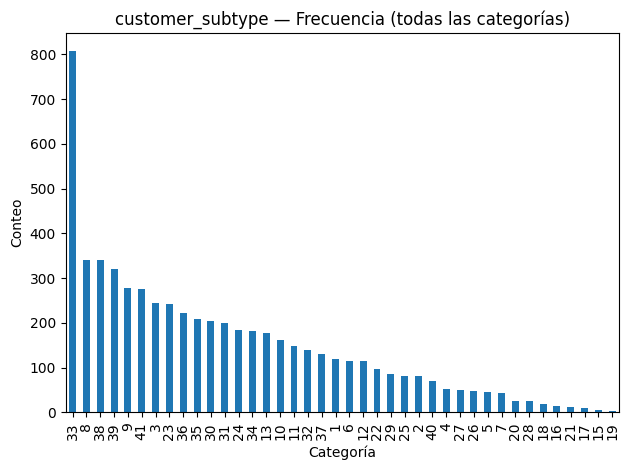

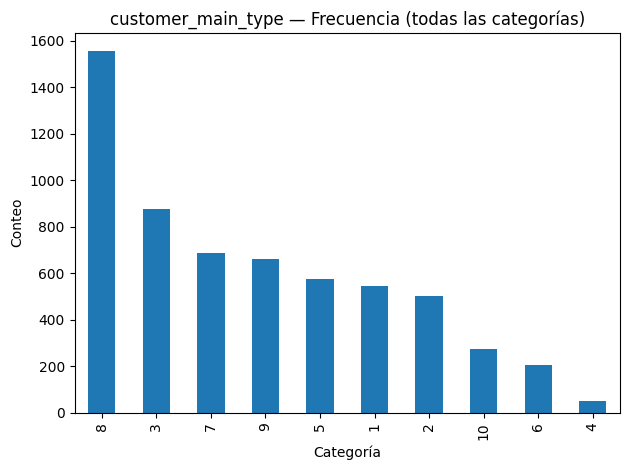

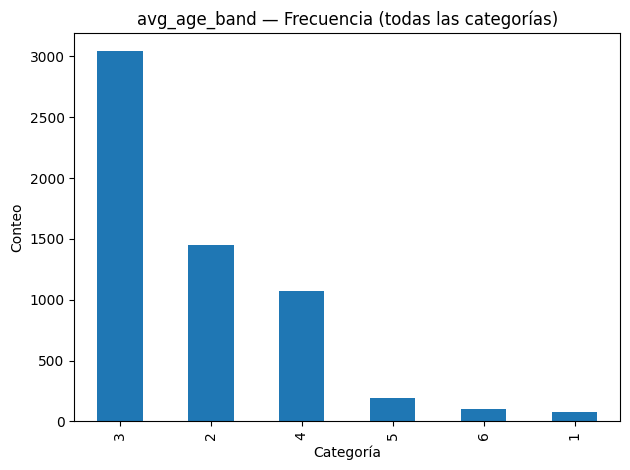

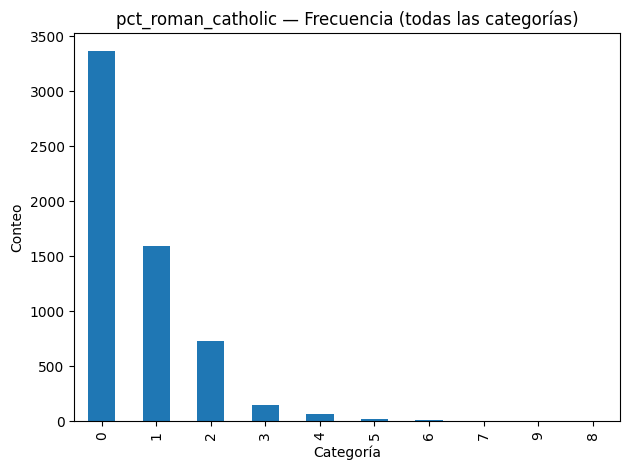

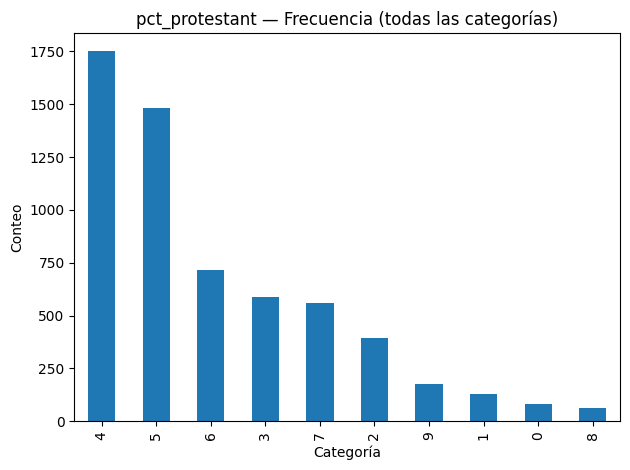

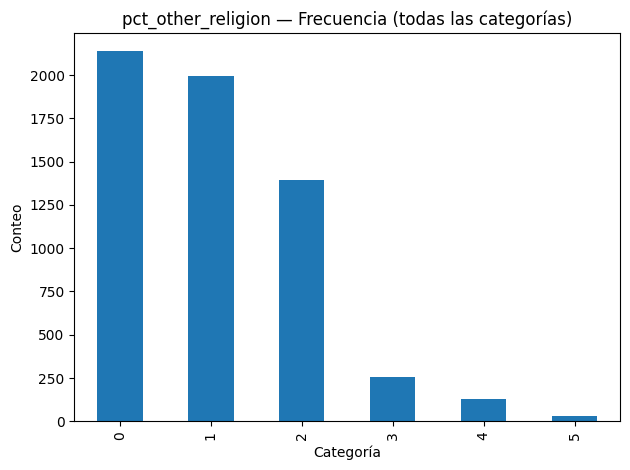

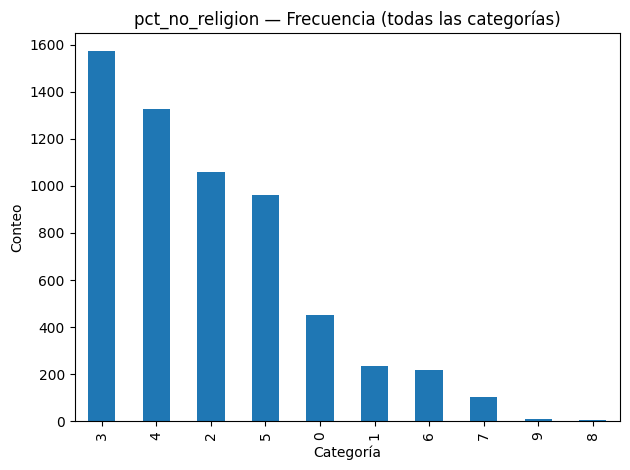

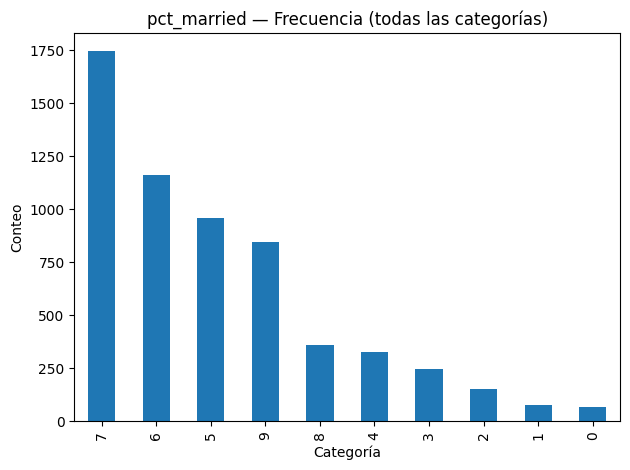

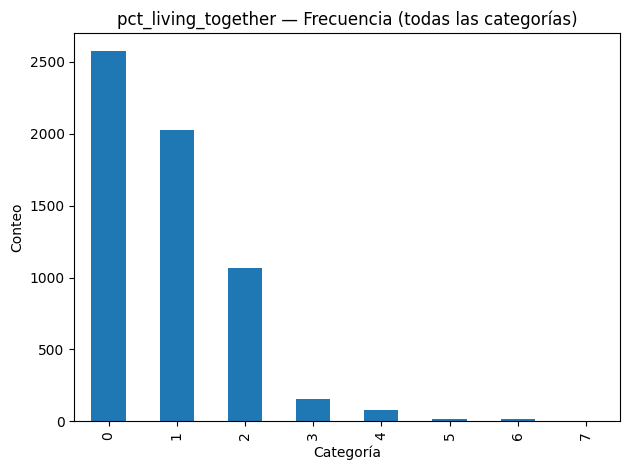

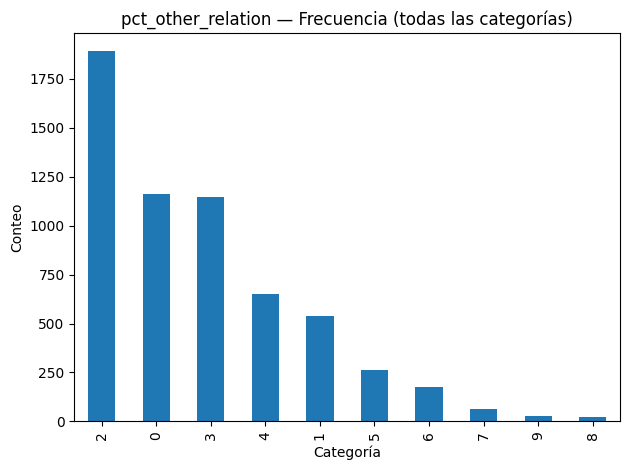

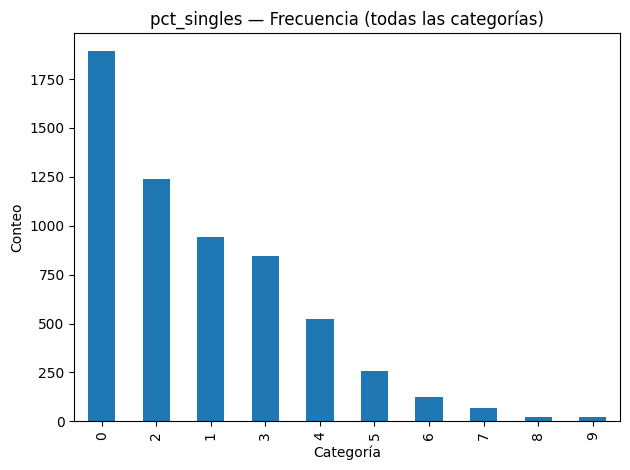

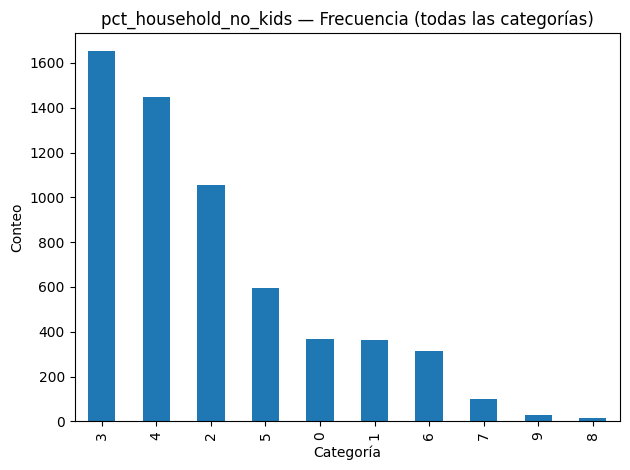

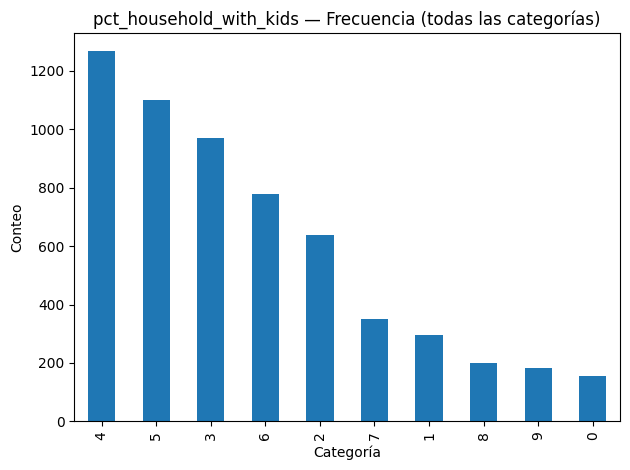

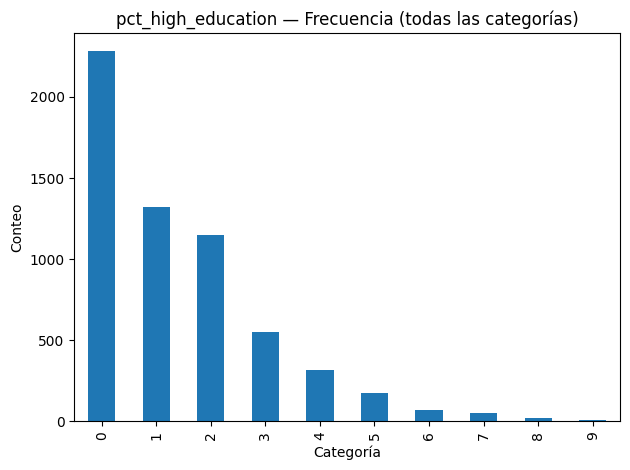

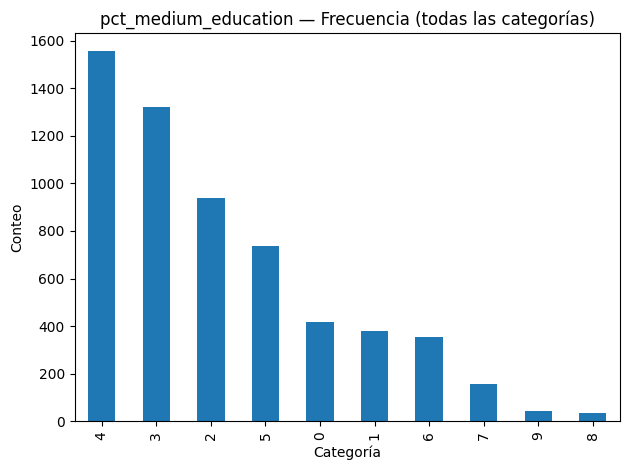

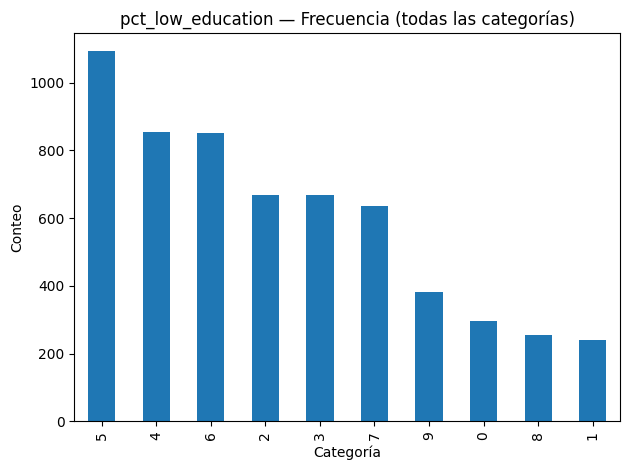

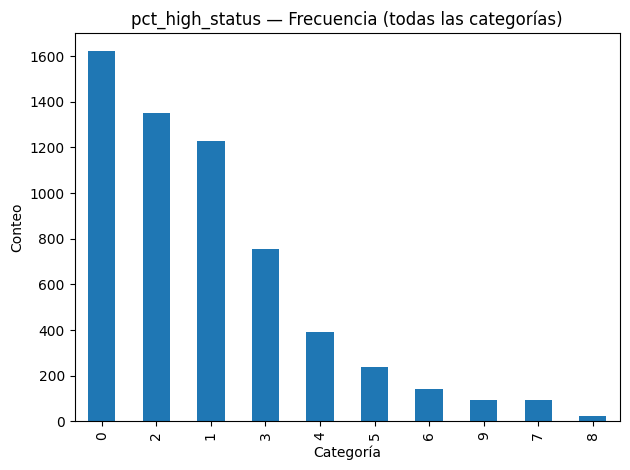

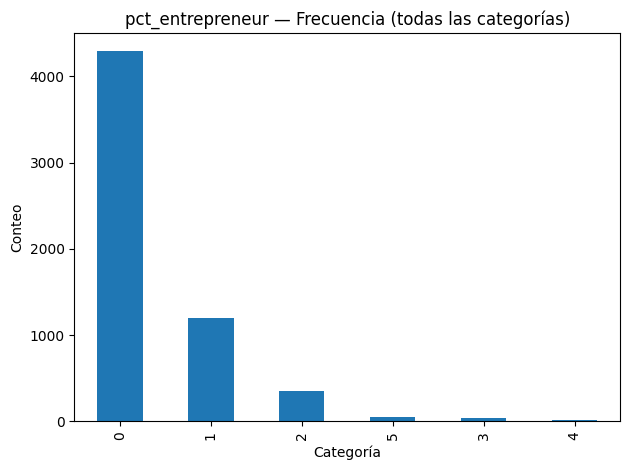

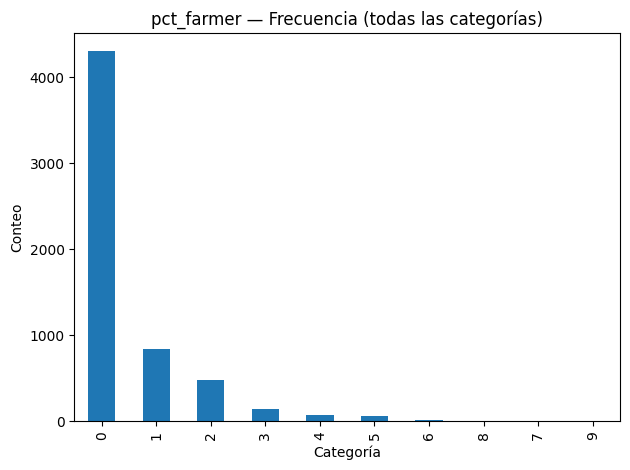

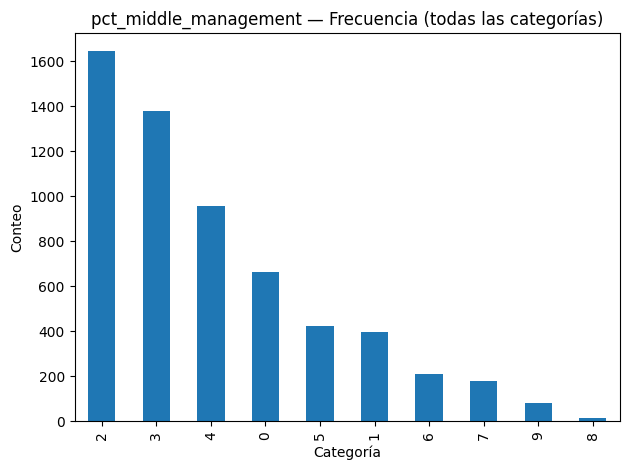

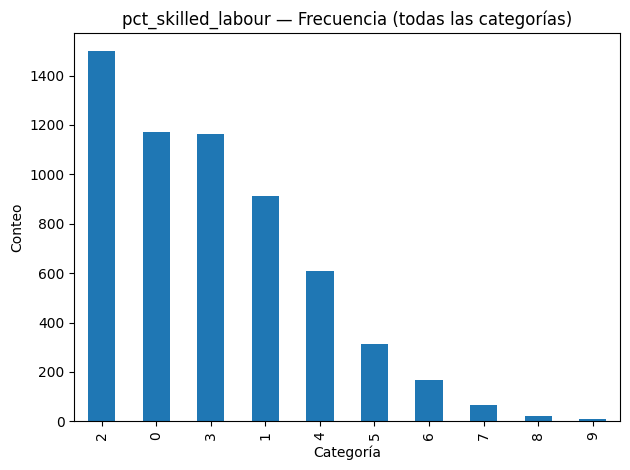

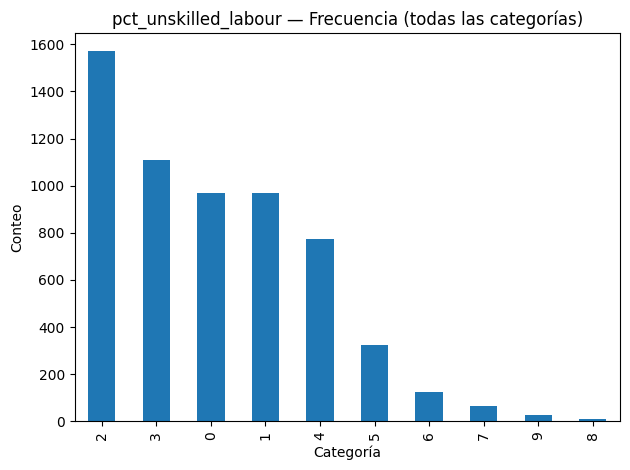

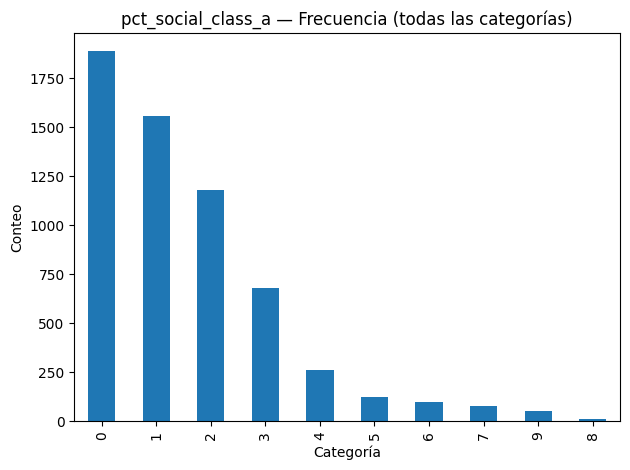

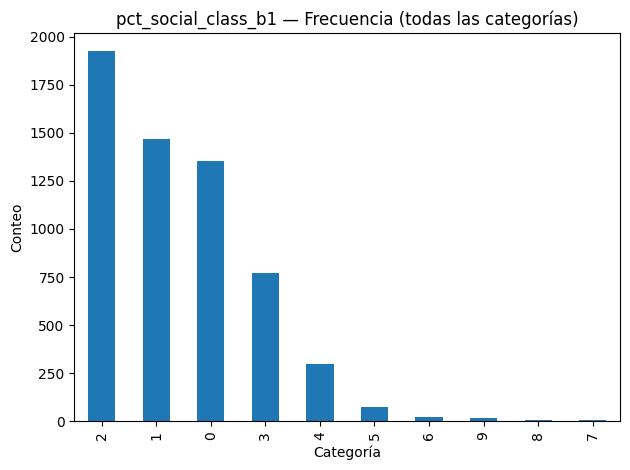

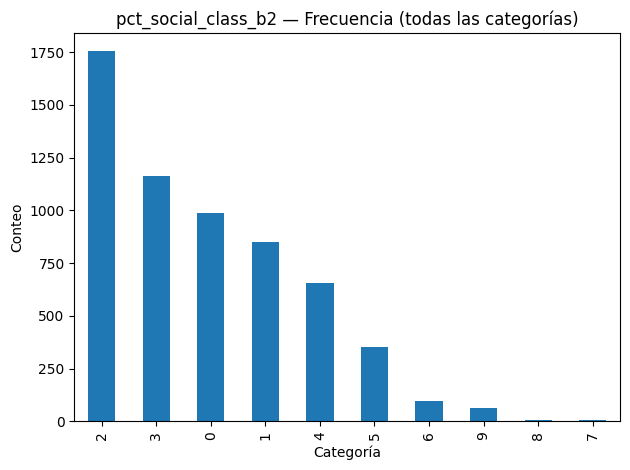

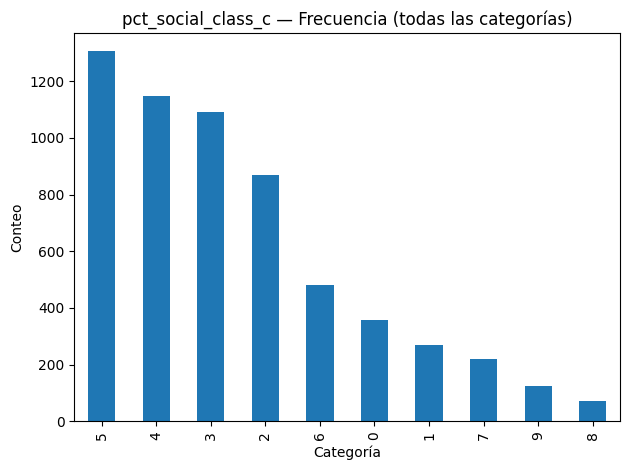

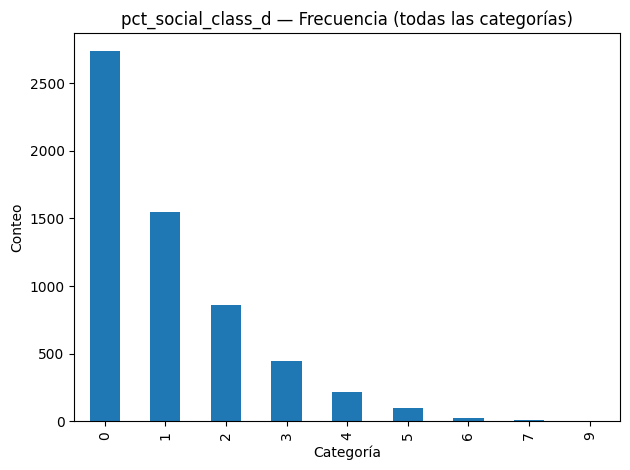

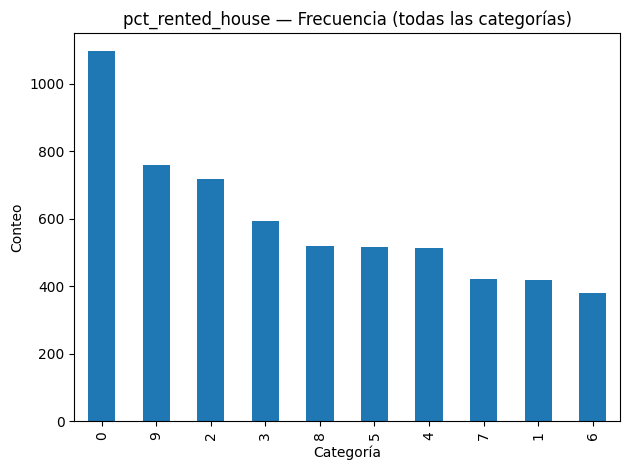

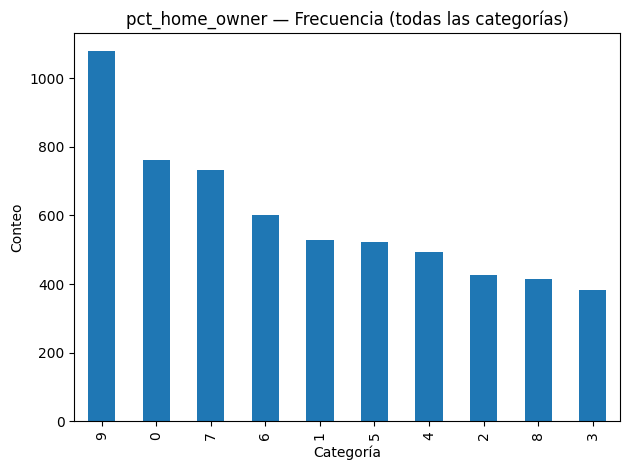

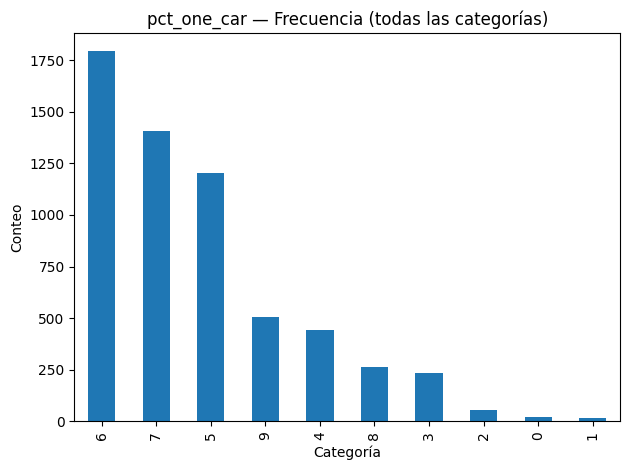

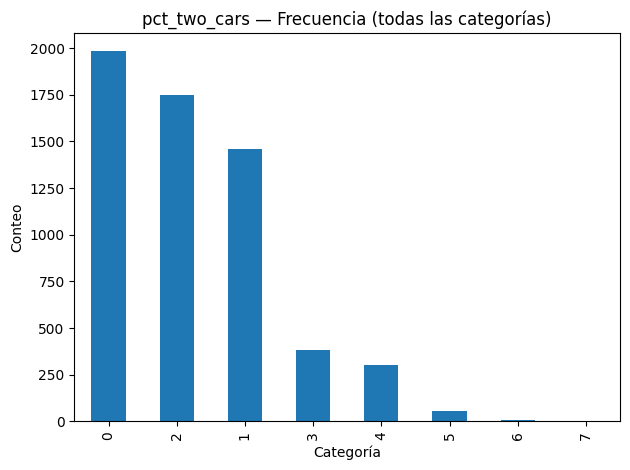

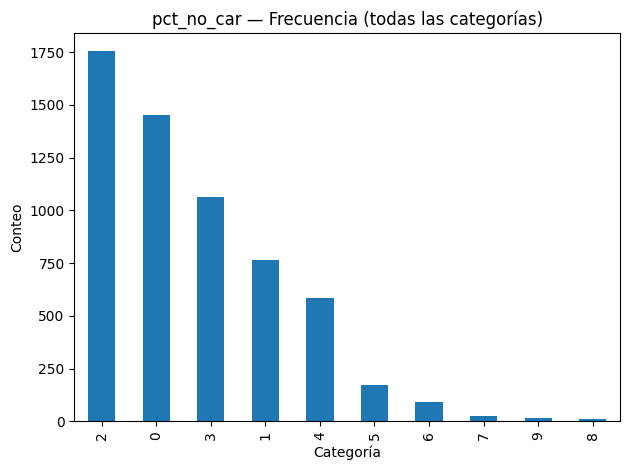

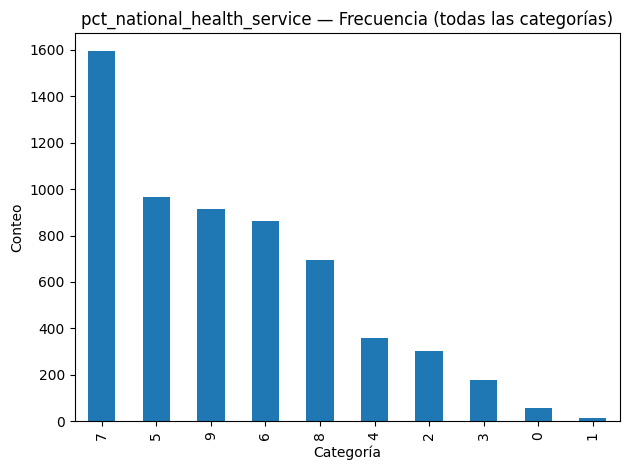

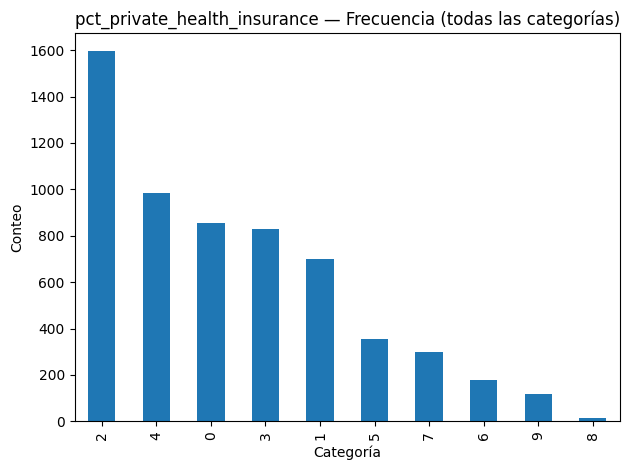

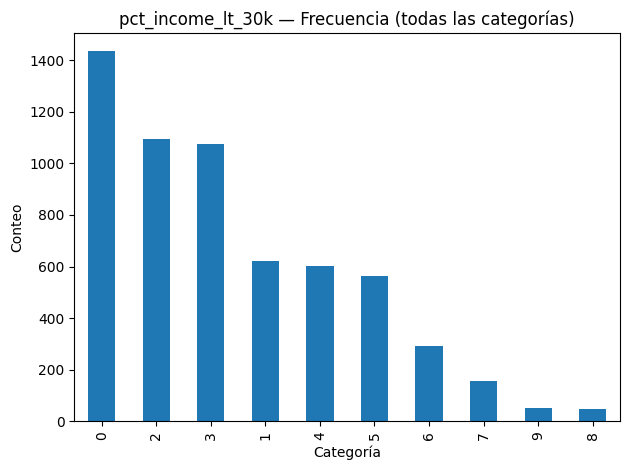

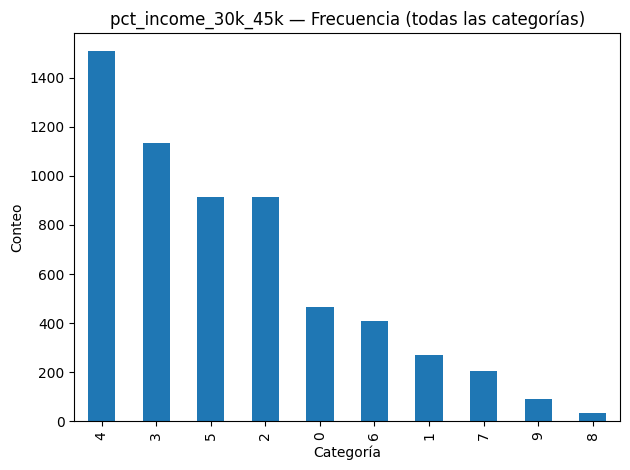

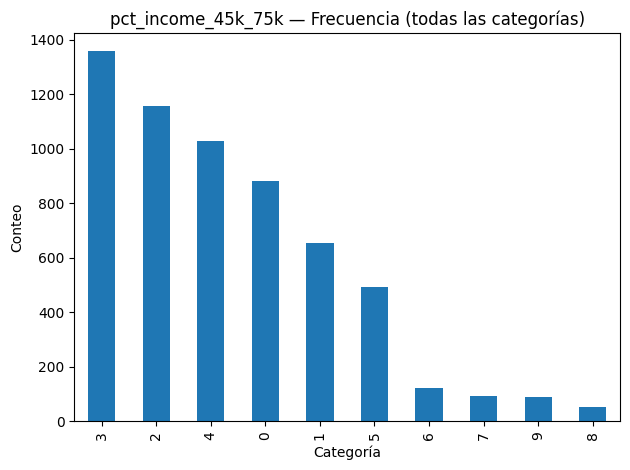

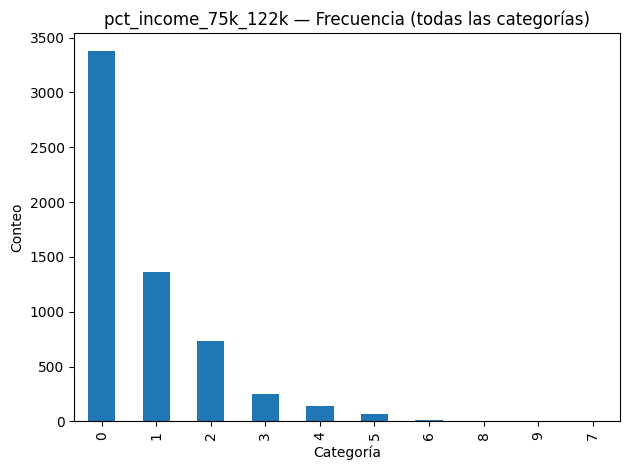

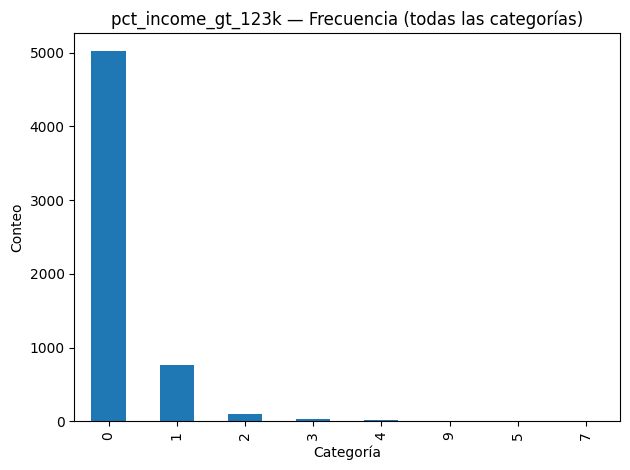

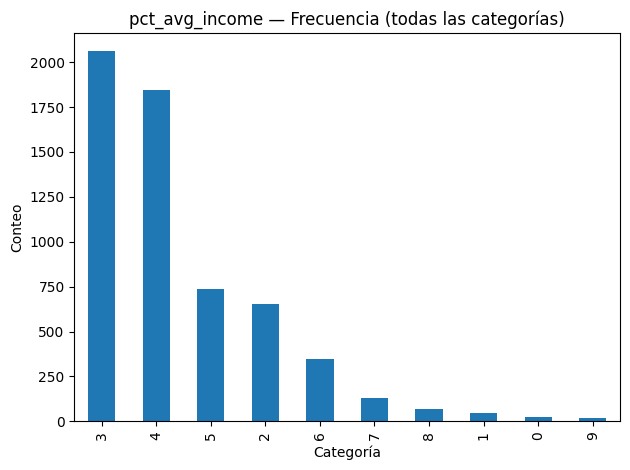

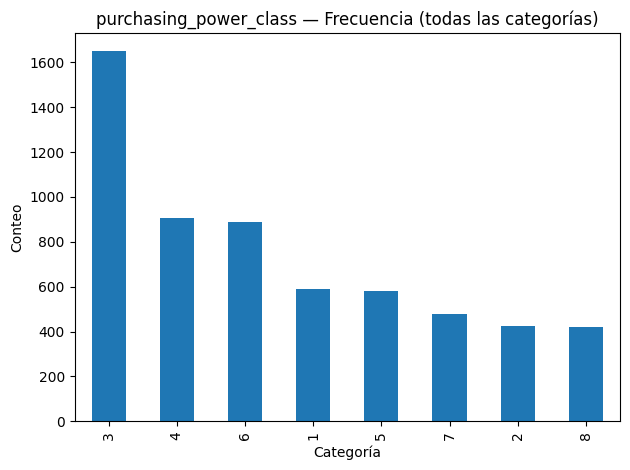

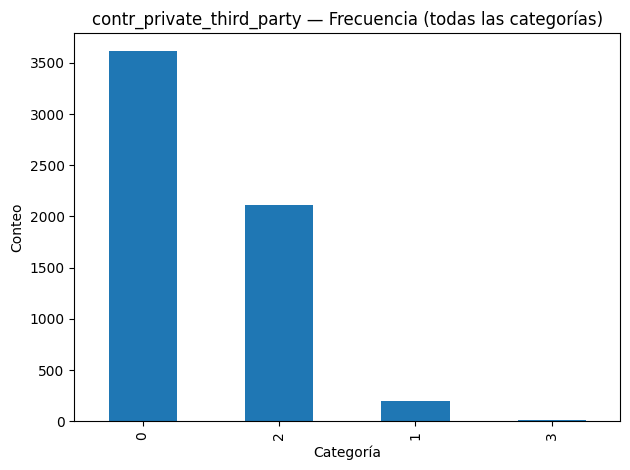

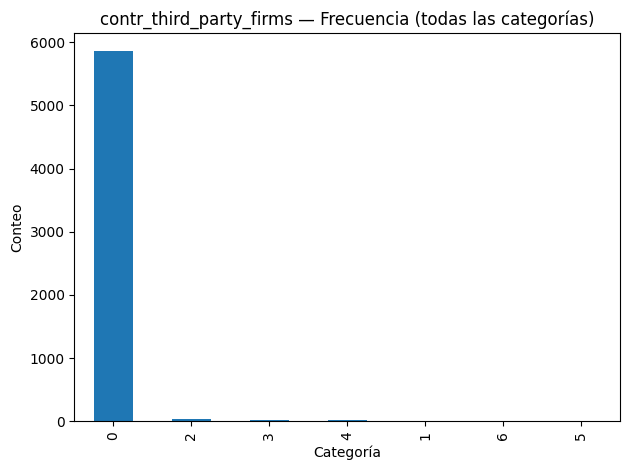

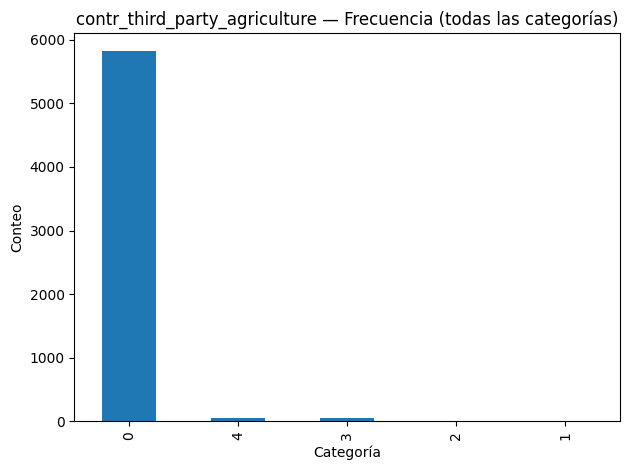

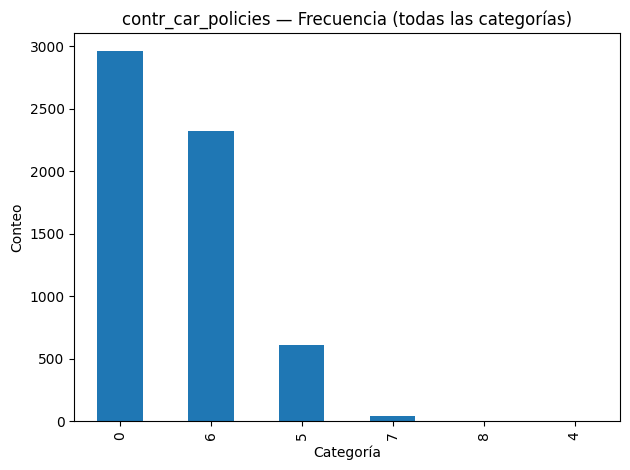

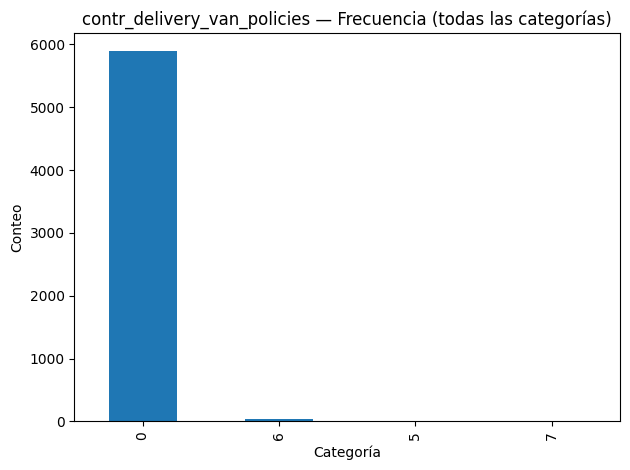

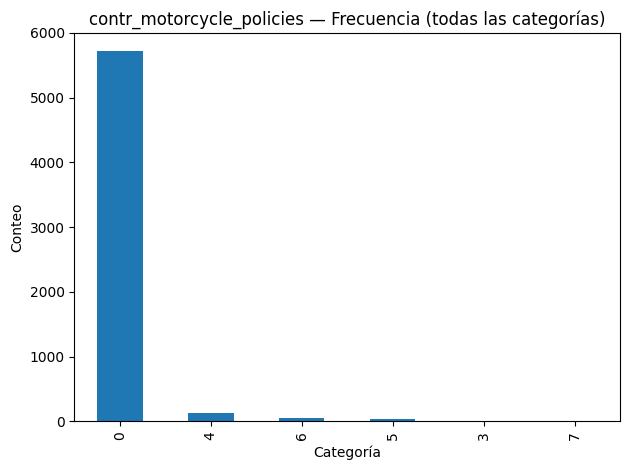

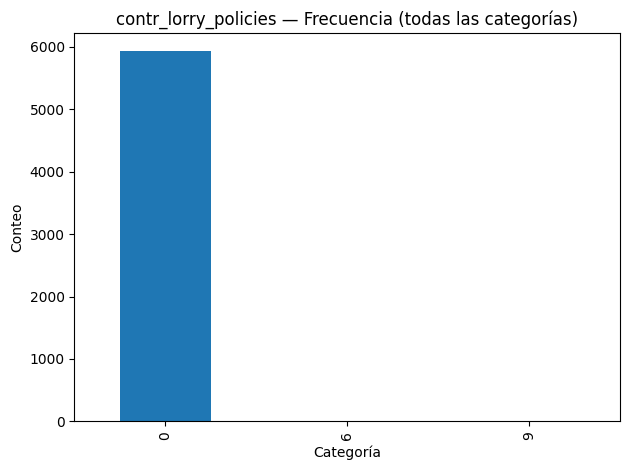

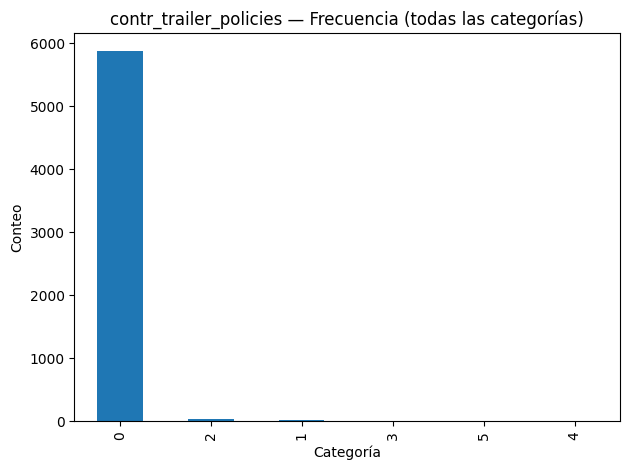

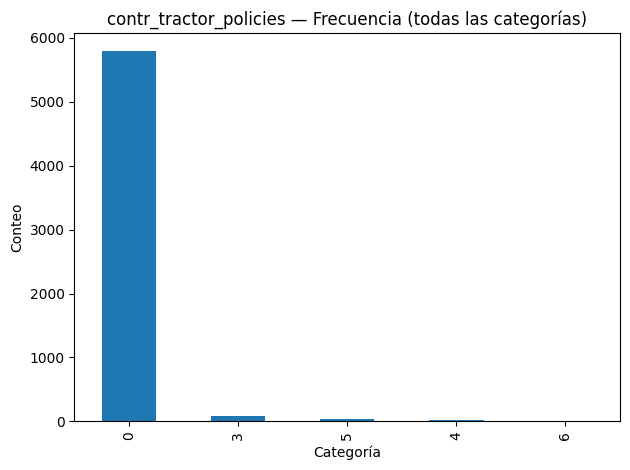

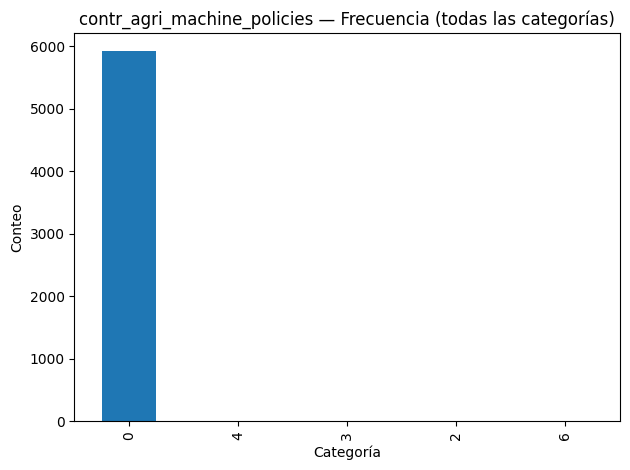

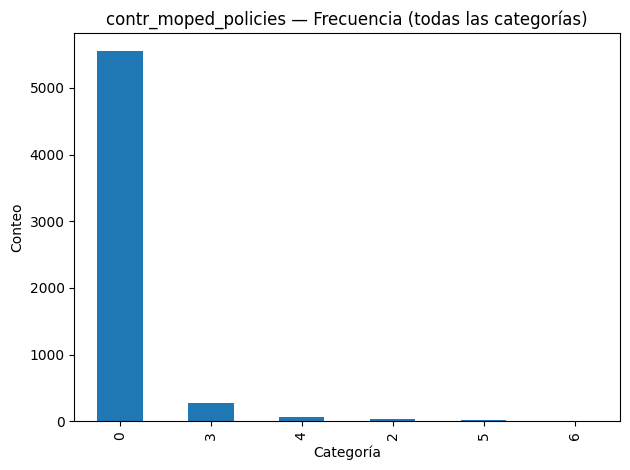

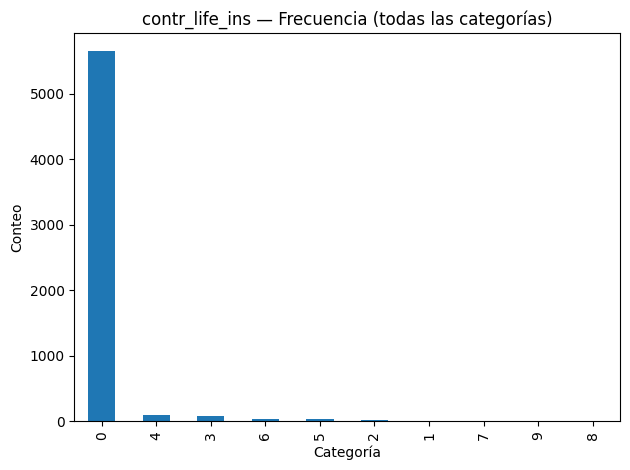

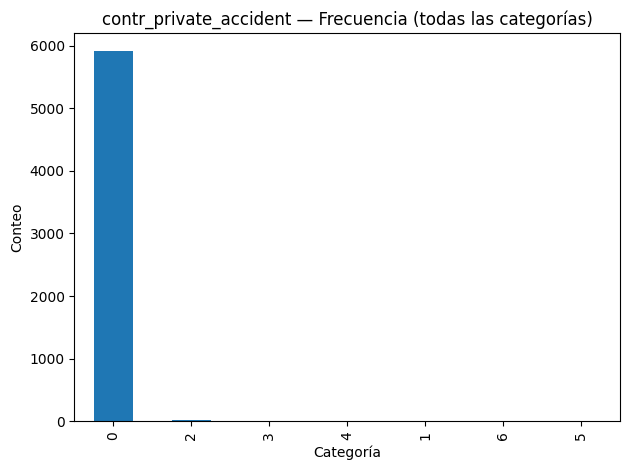

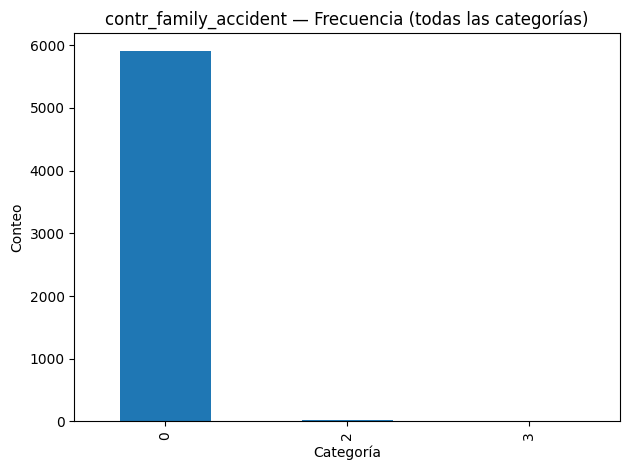

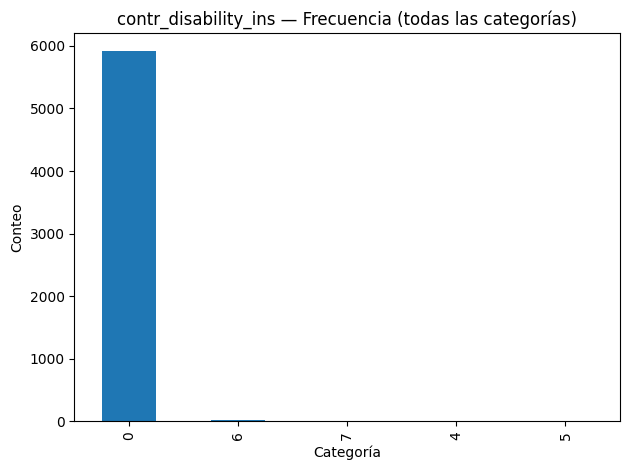

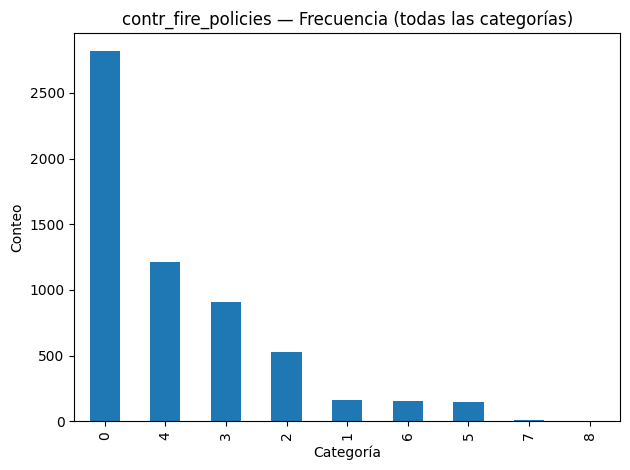

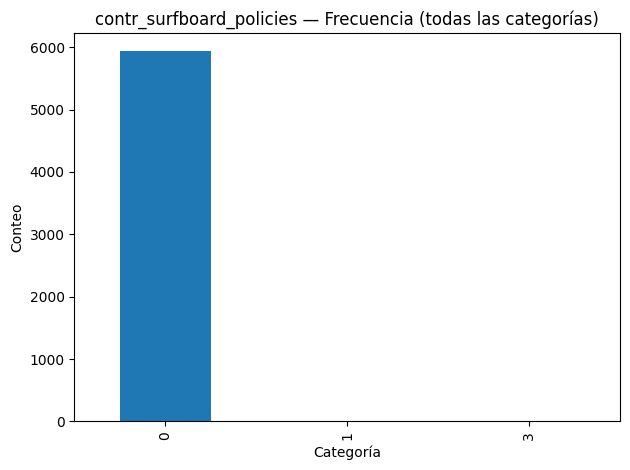

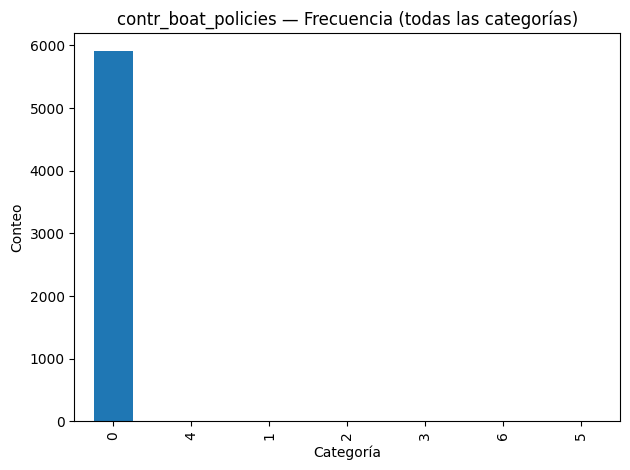

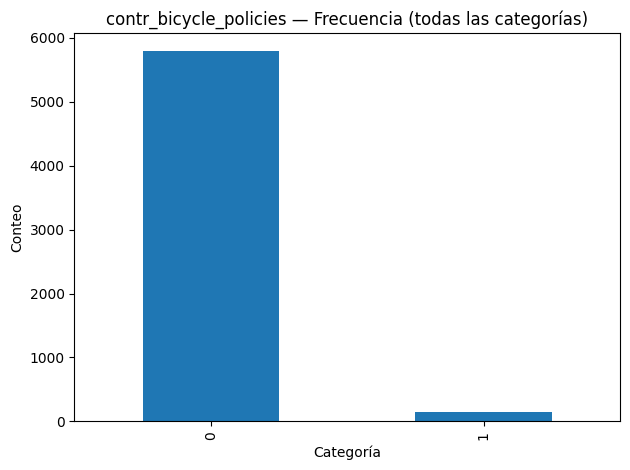

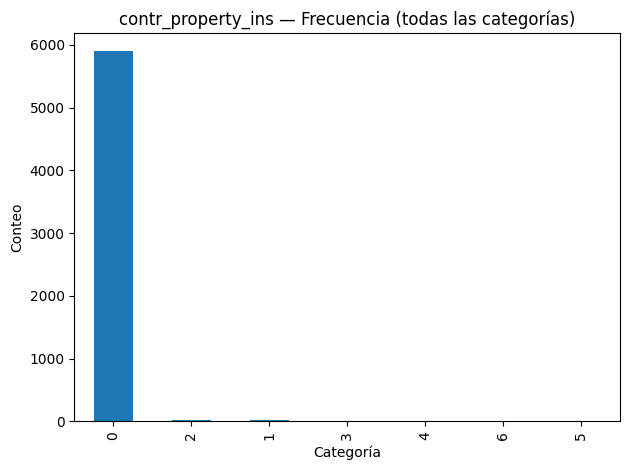

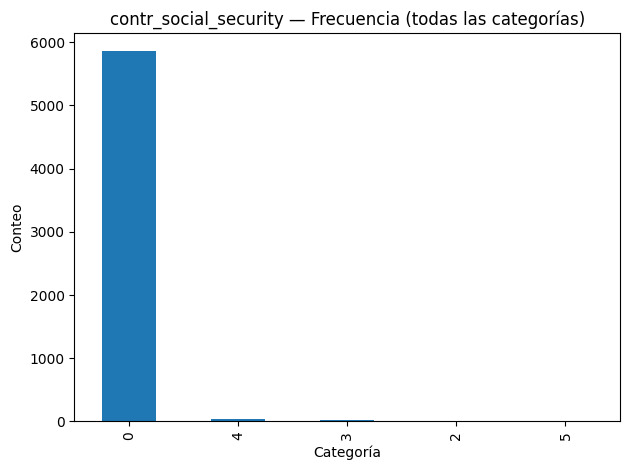

In [17]:
print(f"Total categorical variables: {len(cat_cols_all)}")
print(cat_cols_all)

for c in cat_cols_all:
    vc = df_cleaned[c].value_counts(dropna=False)
    plt.figure()
    vc.plot(kind="bar")
    plt.title(f"{c} — Frecuencia (todas las categorías)")
    plt.xlabel("Categoría")
    plt.ylabel("Conteo")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Now we proceed to plot numeric discrete variables

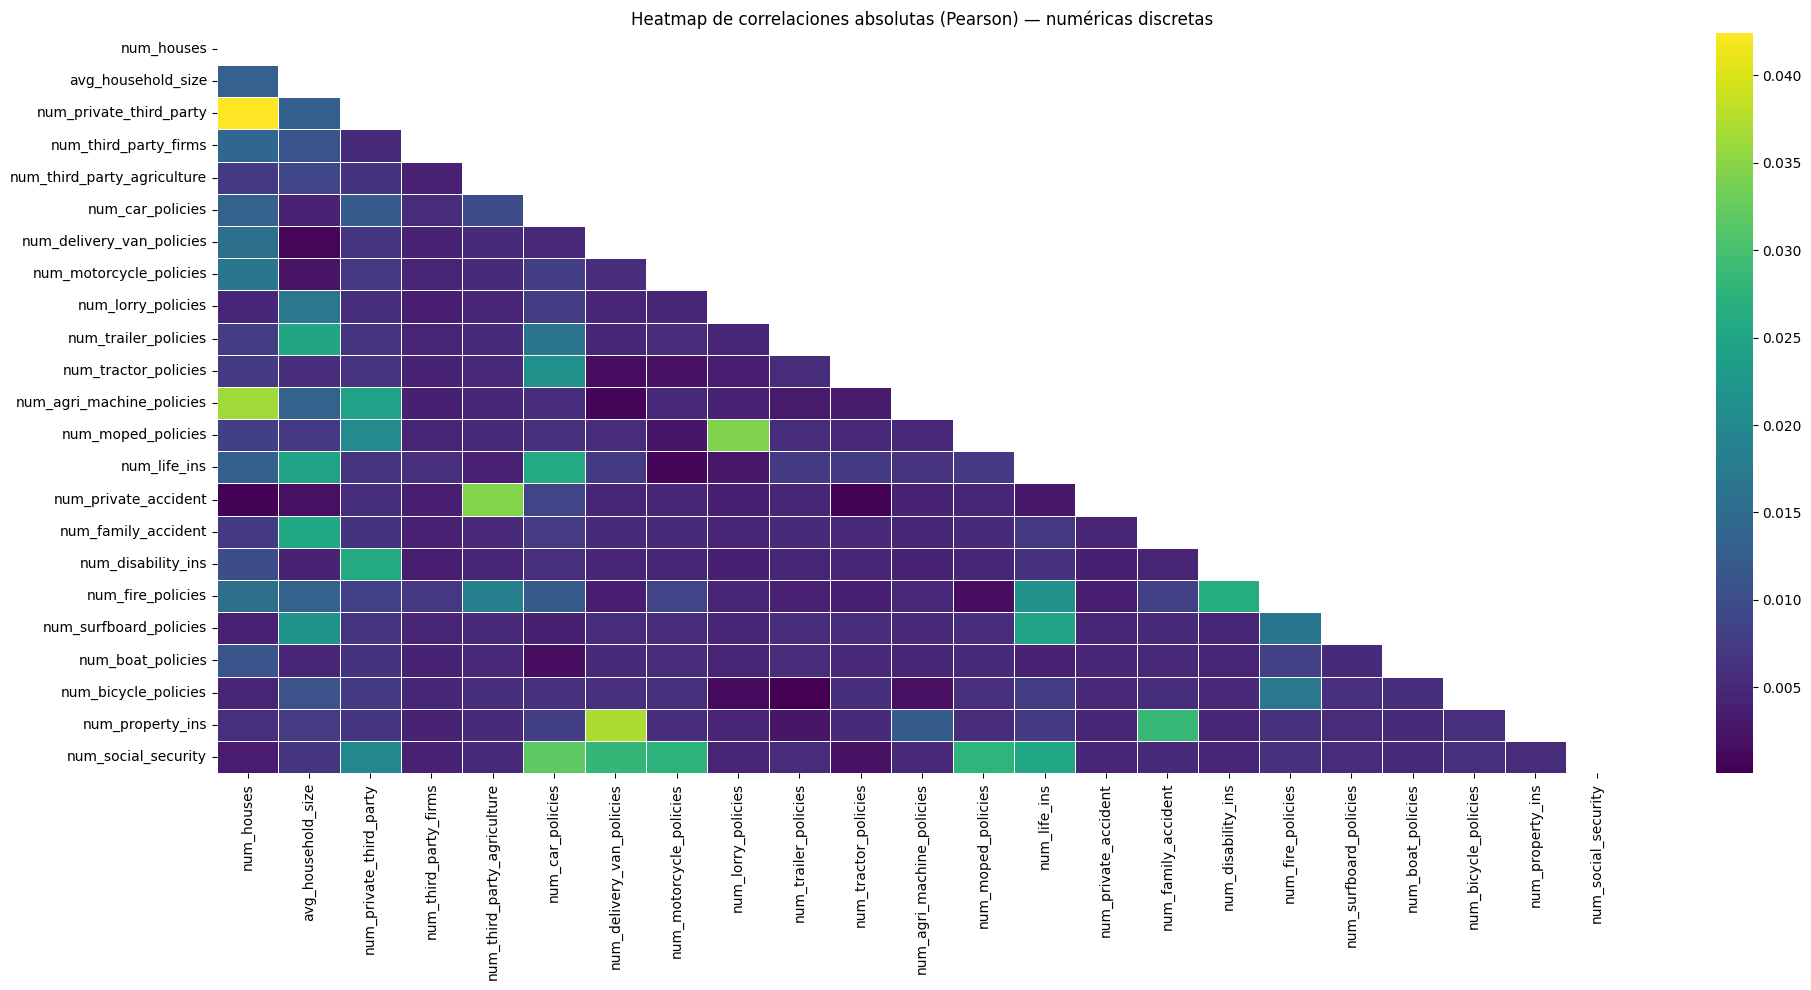

In [18]:
numeric_cols = [c for c in numeric_discrete_cols if c in df_cleaned.columns]
numeric_dataset = df_cleaned[numeric_cols].apply(pd.to_numeric, errors="coerce")

# Matriz de correlación absoluta (Pearson)
corr = numeric_dataset.corr(method='pearson').abs()

# (Opcional) máscara para triangular superior
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 10))
sns.heatmap(
    corr,
    mask=mask,           # elimina esta línea si quieres mostrar toda la matriz
    cmap='viridis',
    linewidths=0.5,
    square=False,
    cbar=True
)
plt.title("Heatmap de correlaciones absolutas (Pearson) — numéricas discretas")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Feature Engineering

During the exploratory data analysis (EDA), we observed high collinearity among certain groups of variables. Specifically, variables that begin with “P” (indicating the percentage or contribution of a type of policy in the area) each have a corresponding “A” variable (representing the absolute number of policies of that type in the area), and these pairs are highly correlated—as shown by the reddish diagonal bands in the correlation matrix. This confirms that each P/A pair conveys the same information on different scales. For example, PBRAND represents the categorized percentage of fire insurance policies in the area, while ABRAND reflects the absolute count of such policies in that zone. Including both in the model introduces redundancy and may lead to noise or overfitting.

A common strategy is to remove one variable from each P/A pair, retaining either the percentage-based variables or the absolute count variables.

In [19]:
# ------------------------------------------------------------------
# 3) Eliminar variables numéricas altamente correlacionadas
#    - Umbral: se define un límite absoluto de correlación (thr=0.95)
#    - Estrategia: se elimina la más redundante según suma de correlaciones
#    - Excluye: la variable objetivo no se considera en el análisis
#    - Salida: DataFrame depurado, lista de columnas eliminadas, resumen
# ------------------------------------------------------------------

def prune_by_correlation(df_copy, target_col="target_caravan", thr=0.95, strategy="sum", random_state=42, verbose=True):
    """
    Remove redundant features by absolute correlation threshold.
    - df: DataFrame
    - target_col: name of target to exclude from correlation
    - thr: absolute correlation threshold above which we consider two features redundant
    - strategy: how to decide which one to drop in a high-correlation pair
        * "sum": drop the one with larger total correlation to others (more redundant globally)
        * "random": drop one at random (reproducible via random_state)
    Returns: pruned_df, dropped_columns, stats_dict
    """
    rng = np.random.RandomState(random_state)

    feat_cols = [c for c in df_copy.columns if c != target_col and pd.api.types.is_numeric_dtype(df_copy[c])]
    if len(feat_cols) < 2:
        return df_copy.copy(), [], {"reason": "not_enough_numeric", "n_features_original": len(feat_cols)}

    corr = df_copy[feat_cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    to_drop = set()
    kept = set(feat_cols)

    # Greedy elimination
    for col in upper.columns:
        # candidates highly correlated with col
        high_pairs = upper[col][upper[col] > thr].dropna()
        for row, val in high_pairs.items():
            if row in kept and col in kept:
                if strategy == "sum":
                    s_row = corr[row].sum()
                    s_col = corr[col].sum()
                    drop = row if s_row >= s_col else col
                else:  # random
                    drop = rng.choice([row, col])
                kept.discard(drop)
                to_drop.add(drop)

    pruned_df = df_copy.drop(columns=list(to_drop), errors="ignore")
    stats = {
        "n_features_original": len(feat_cols),
        "threshold": thr,
        "n_dropped": len(to_drop),
        "n_features_after_pruning": len(feat_cols) - len(to_drop)
    }
    if verbose:
        print("Pruning stats:", stats)
    return pruned_df, sorted(list(to_drop)), stats

# Run pruning
df_pruned, dropped_cols, stats_corr = prune_by_correlation(df_cleaned, target_col="CARAVAN", thr=0.85, strategy="sum", verbose=True)
print("Dropped (sample):", dropped_cols[:20])
print("Original shape:", df_cleaned.shape, "-> Pruned shape:", df_pruned.shape)

Pruning stats: {'n_features_original': 86, 'threshold': 0.85, 'n_dropped': 4, 'n_features_after_pruning': 82}
Dropped (sample): ['customer_subtype', 'pct_national_health_service', 'pct_other_relation', 'pct_rented_house']
Original shape: (5938, 86) -> Pruned shape: (5938, 82)


Now, we will proceed to define the transformers according to the corresponding variable types.

In [20]:
# ------------------------------------------------------------------
# 4) Definir transformadores por tipo
#    - Nominales -> OneHotEncoder
#    - Ordinales -> mantener como enteros ordenados + StandardScaler
#    - Numéricas discretas -> log1p (opcional) + RobustScaler (resistente a colas/outliers)
# ------------------------------------------------------------------

te = OneHotEncoder(handle_unknown="ignore", sparse_output=False) # codificamos las variables categóricas nominales.

ordinal_transformer = StandardScaler()  # ya están codificadas 0..9 o en bandas crecientes por lo que solo estandarizaremos.

numeric_discrete_transformer = Pipeline(steps=[
    ("log1p", FunctionTransformer(np.log1p, validate=False)),  # estabiliza sesgos si hay muchos ceros/colas
    ("scaler", RobustScaler())
])

# ------------------------------------------------------------------
# 5) Definir ColumnTransformer
# ------------------------------------------------------------------

preprocessor = ColumnTransformer(
    transformers=[
        ("nom", te, nominal_cols),
        ("ord", ordinal_transformer, ordinal_cols),
        ("num", numeric_discrete_transformer, numeric_discrete_cols),
    ],
    remainder="drop"
)

# Splitting the dataset

The dataset is split into separate subsets: training, validation, and test sets.

In [21]:
# ------------------------------------------------------------
# 7) Partición: Train / Valid / Test (estratificada)
#    - Train: 60% del total
#    - Test: 20% del total
#    - Valid: 20% del total
# ------------------------------------------------------------

# Separar variables dependientes e independiente
y = df_cleaned["target_caravan"].astype(int)
X = df_cleaned.drop(columns=["target_caravan"])

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
)

# Models

Custom functions are implemented for metrics that are especially useful in binary classification problems with imbalanced classes, as is the case in our dataset.

In [22]:
# ------------------------------------------------------------
# 6) Métricas y selección de umbral por G-Mean en VALID
# ------------------------------------------------------------
def specificity_score(y_true, y_pred):
    # TN / (TN + FP)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0.0

def gmean_at_threshold(y_true, y_proba, thr):
    y_hat = (y_proba >= thr).astype(int)
    rec = recall_score(y_true, y_hat)             # Sensitivity
    spc = specificity_score(y_true, y_hat)        # Specificity
    return np.sqrt(rec * spc), rec, spc

A logistic regression model is proposed as a baseline or starting point for the analysis.

In [23]:
# ------------------------------------------------------------
# 8) Pipeline final con Regresión Logística
#    - class_weight='balanced' para desbalance
# ------------------------------------------------------------
clf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced", # dataset muy desbalanceado
    solver="lbfgs",
    n_jobs=-1
)

pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", clf)
])

# Entrenar
pipe.fit(X_train, y_train)

# Probabilidades en valid y test
p_valid = pipe.predict_proba(X_valid)[:, 1]
p_test  = pipe.predict_proba(X_test)[:, 1]

# Métricas umbral-independientes en VALID
ap_valid  = average_precision_score(y_valid, p_valid)
roc_valid = roc_auc_score(y_valid, p_valid)

# Buscar umbral óptimo por G-Mean
thresholds = np.linspace(0.01, 0.99, 99)
gmeans, recs, spcs = [], [], []
for t in thresholds:
    g, r, s = gmean_at_threshold(y_valid, p_valid, t)
    gmeans.append(g); recs.append(r); spcs.append(s)

best_idx = int(np.argmax(gmeans))
best_thr = float(thresholds[best_idx])
best_gmean_valid = float(gmeans[best_idx])

# ------------------------------------------------------------
# 9) Evaluación
# ------------------------------------------------------------
ap_test  = average_precision_score(y_test, p_test)
roc_test = roc_auc_score(y_test, p_test)

yhat_test = (p_test >= best_thr).astype(int)
gmean_test, rec_test, spc_test = gmean_at_threshold(y_test, p_test, best_thr)

yhat_valid = (p_valid >= best_thr).astype(int)
f1_valid = f1_score(y_valid, yhat_valid)
f1_test  = f1_score(y_test, yhat_test)

print("=== VALIDACIÓN (para selección de umbral) ===")
print(f"Average Precision (PR-AUC): {ap_valid:0.4f}")
print(f"ROC-AUC:                   {roc_valid:0.4f}")
print(f"Best threshold (G-Mean):   {best_thr:0.3f}")
print(f"G-Mean @best_thr:          {best_gmean_valid:0.4f}")
print(f"F1-score @best_thr:        {f1_valid:0.4f}")

print("\n=== PRUEBA (umbral fijado en valid) ===")
print(f"Average Precision (PR-AUC): {ap_test:0.4f}")
print(f"ROC-AUC:                   {roc_test:0.4f}")
print(f"G-Mean @thr={best_thr:0.3f}: {gmean_test:0.4f}")
print(f"  - Recall (TPR):          {rec_test:0.4f}")
print(f"  - Specificity (TNR):     {spc_test:0.4f}")
print(f"F1-score:                  {f1_test:0.4f}")

# Matriz de confusión en test
print("\nConfusion Matrix (Test)")
print(confusion_matrix(y_test, yhat_test, labels=[0,1]))

=== VALIDACIÓN (para selección de umbral) ===
Average Precision (PR-AUC): 0.1513
ROC-AUC:                   0.7088
Best threshold (G-Mean):   0.360
G-Mean @best_thr:          0.6611
F1-score @best_thr:        0.1805

=== PRUEBA (umbral fijado en valid) ===
Average Precision (PR-AUC): 0.1455
ROC-AUC:                   0.6568
G-Mean @thr=0.360: 0.5956
  - Recall (TPR):          0.6000
  - Specificity (TNR):     0.5912
F1-score:                  0.1476

Confusion Matrix (Test)
[[661 457]
 [ 28  42]]


Building on the results of the previously proposed baseline model, we now proceed to tackle the problem using an XGBoost model.

In [24]:
# ------------------------------------------------------------
# 10) Pipeline final con XGBoost (pos_weight) + RandomizedSearchCV
#    - pos_weight para desbalance
# ------------------------------------------------------------

# ---- Calcular ratio para scale_pos_weight ----
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
ratio = neg / max(1, pos)

# ---- XGBoost ----
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",           # PR-AUC para desbalance
    random_state=42,
    n_jobs=-1,
    tree_method="hist",
    enable_categorical=False
)

pipe_xgb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", xgb)
])

# ----- Espacio de búsqueda -----
param_dist = {
    "model__n_estimators":      [300, 500, 800, 1000, 1200, 1500],
    "model__max_depth":         [4, 5, 6, 7, 8],
    "model__learning_rate":     [0.01, 0.05, 0.1, 0.15, 0.2],
    "model__subsample":         [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree":  [0.7, 0.8, 0.9, 1.0],
    "model__min_child_weight":  [1, 3, 5, 7],
    "model__gamma":             [0, 0.1, 0.3, 0.5, 1.0],
    "model__reg_alpha":         [0, 0.001, 0.01, 0.1, 1.0],
    "model__reg_lambda":        [0.1, 0.5, 1.0, 2.0, 5.0],
    "model__scale_pos_weight":  [1, ratio, ratio/2, ratio*1.5, np.sqrt(ratio), 10, 15, 20]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_dist,
    n_iter=167,
    scoring="average_precision",  # métrica principal para elegir el mejor (ideal para clases desbalanceadas)
    n_jobs=-1,
    cv=cv,
    refit=True,
    verbose=1,
    random_state=42
)

# ----- Búsqueda en TRAIN -----
search.fit(X_train, y_train)

print("=== RandomizedSearchCV ===")
print("Best AP (cv):", f"{search.best_score_:.4f}")
print("Best Params:")
for k, v in search.best_params_.items():
    print(f"  {k}: {v}")

best_pipe = search.best_estimator_  # pipeline ya reentrenado en todo TRAIN

# ----- Probabilidades en VALID para elegir umbral por G-Mean -----
p_valid = best_pipe.predict_proba(X_valid)[:, 1]
ap_valid  = average_precision_score(y_valid, p_valid)
roc_valid = roc_auc_score(y_valid, p_valid)

# Buscar umbral óptimo por G-Mean
thresholds = np.linspace(0.01, 0.5, 50)
gmeans, recs, spcs = [], [], []
for t in thresholds:
    g, r, s = gmean_at_threshold(y_valid, p_valid, t)
    gmeans.append(g); recs.append(r); spcs.append(s)

best_idx = int(np.argmax(gmeans))
best_thr = float(thresholds[best_idx])
best_gmean_valid = float(gmeans[best_idx])

# ------------------------------------------------------------
# 11) Evaluación
# ------------------------------------------------------------
yhat_valid = (p_valid >= best_thr).astype(int)
f1_valid = f1_score(y_valid, yhat_valid)

print("\n=== VALIDACIÓN (selección de umbral) ===")
print(f"Average Precision (PR-AUC): {ap_valid:0.4f}")
print(f"ROC-AUC:                   {roc_valid:0.4f}")
print(f"Best threshold (G-Mean):   {best_thr:0.3f}")
print(f"G-Mean @best_thr:          {best_gmean_valid:0.4f}")
print(f"F1-score @best_thr:        {f1_valid:0.4f}")

# --- TEST ---
p_test  = best_pipe.predict_proba(X_test)[:, 1]
ap_test  = average_precision_score(y_test, p_test)
roc_test = roc_auc_score(y_test, p_test)
yhat_test = (p_test >= best_thr).astype(int)
gmean_test, rec_test, spc_test = gmean_at_threshold(y_test, p_test, best_thr)
f1_test  = f1_score(y_test, yhat_test)

print("\n=== PRUEBA (umbral fijado desde VALID) ===")
print(f"Average Precision (PR-AUC): {ap_test:0.4f}")
print(f"ROC-AUC:                    {roc_test:0.4f}")
print(f"G-Mean  @thr={best_thr:0.3f}: {gmean_test:0.4f}")
print(f"  - Recall (TPR):           {rec_test:0.4f}")
print(f"  - Specificity (TNR):      {spc_test:0.4f}")
print(f"F1-score:                   {f1_test:0.4f}")

# Matriz de confusión en test
print("\nConfusion Matrix (Test)")
print(confusion_matrix(y_test, yhat_test, labels=[0,1]))

Fitting 3 folds for each of 167 candidates, totalling 501 fits
=== RandomizedSearchCV ===
Best AP (cv): 0.1548
Best Params:
  model__subsample: 1.0
  model__scale_pos_weight: 7.940758293838862
  model__reg_lambda: 0.1
  model__reg_alpha: 0
  model__n_estimators: 300
  model__min_child_weight: 1
  model__max_depth: 4
  model__learning_rate: 0.01
  model__gamma: 0.3
  model__colsample_bytree: 0.8

=== VALIDACIÓN (selección de umbral) ===
Average Precision (PR-AUC): 0.1938
ROC-AUC:                   0.7584
Best threshold (G-Mean):   0.270
G-Mean @best_thr:          0.6968
F1-score @best_thr:        0.2065

=== PRUEBA (umbral fijado desde VALID) ===
Average Precision (PR-AUC): 0.1516
ROC-AUC:                    0.7231
G-Mean  @thr=0.270: 0.6693
  - Recall (TPR):           0.6714
  - Specificity (TNR):      0.6673
F1-score:                   0.1922

Confusion Matrix (Test)
[[746 372]
 [ 23  47]]
